In [1]:
import scipy as sp
import scipy.io
import os
import numpy as np
import pandas as pd
import random as rand
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as mpl
import colorlover as cl
from scipy import stats
import importlib
import sys
sys.path.append(os.getcwd()+'\\..\\')
import matplotlib.patches as patches
from matplotlib import gridspec
# from utils import zscores
# from utils import utils
# from utils import plotting_utils as pu
# from utils import auc_methods
%load_ext autoreload
%autoreload 2
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


## If exporting figures for adobe illustrator

In [2]:
mpl.close('all')

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 6}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=6) 
mpl.rc('ytick', labelsize=6)
mpl.rc('axes', labelsize=6)


mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
size_mult = 0.33

## If plotting for inline visualization

In [3]:
mpl.close('all')

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=14)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
size_mult = 1

### Load main data files

In [4]:
data_directory = r'C:\Users\efink\Documents\DATA\Crossmodal_only'
# log_df, unit_key_df = utils.load_data(data_directory)
# # log_df = utils.filt_motion_trials(log_df, data_directory)
# log_df.tail()

# unit_key_df = utils.calc_unit_stats(unit_key_df, log_df, bin_size)

# log_df['spike_counts(stim_aligned)'] = log_df['spike_times(stim_aligned)'].apply(lambda x: np.histogram(x,edges)[0]/bin_size)

# unit_key_df = zscores.calc_z_scores(log_df, unit_key_df, bin_size, window)

# #### drop units that have a baseline mean and std of 0 otherwise Z-score will be NaN
# unit_key_df = unit_key_df[~(unit_key_df['FR_std'] == 0)]

##### uncomment below if the processed data is already saved
log_df = pd.read_hdf(f'{data_directory}/log_df_processed_03-03-2019.h5', 'fixed')
unit_key_df = pd.read_hdf(f'{data_directory}/unit_key_df_processed_03-03-2019.h5', 'fixed')

In [5]:
tactile_lick_noLick_aucs = pd.read_hdf(r'C:\Users\efink\Documents\DATA\Crossmodal_only\Touch_lick_no_lick_auc_2019-02-27.h5', 'table')
visual_lick_noLick_aucs = pd.read_hdf(r'C:\Users\efink\Documents\DATA\Crossmodal_only\Visual_lick_no_lick_auc_2019-02-27.h5', 'table')
touch_detect_prob_auc = pd.read_hdf(r'C:\Users\efink\Documents\DATA\Crossmodal_only\Touch_lick_no_lick_auc_2019-02-27.h5', 'table')
visual_detect_prob_auc = pd.read_hdf(r'C:\Users\efink\Documents\DATA\Crossmodal_only\Visual_lick_no_lick_auc_2019-02-27.h5', 'table')

tac_aucs = tactile_lick_noLick_aucs.merge(unit_key_df['uni_id'].to_frame(), how = 'right')
vis_aucs = visual_lick_noLick_aucs.merge(unit_key_df['uni_id'].to_frame(), how = 'right')

tac_SPs = touch_detect_prob_auc.merge(unit_key_df['uni_id'].to_frame(), how = 'right')
vis_SPs = visual_detect_prob_auc.merge(unit_key_df['uni_id'].to_frame(), how = 'right')

In [6]:
### slice auc value and upper and lower confidence intervals

up_arrays = []
down_arrays = []
c_arrays = []
for c_array in [vis_SPs, tac_SPs, tac_aucs, vis_aucs]:
    up_cols = c_array.columns[c_array.columns.str.contains('up')]
    down_cols = c_array.columns[c_array.columns.str.contains('low')]
    auc_cols = c_array.columns[c_array.columns.str.contains('auc')]

    if len(down_cols)<100:
        auc_cols = list(auc_cols[9:41])
        up_cols = list(up_cols[9:41])
        down_cols = list(down_cols[9:41])
    else:
        auc_cols = list(auc_cols[38:])
        up_cols = list(up_cols[38:])
        down_cols = list(down_cols[38:])
        
    c_arrays.append(c_array.loc[:, ['uni_id'] + auc_cols])    
    up_arrays.append(c_array.loc[:, ['uni_id'] + up_cols])
    down_arrays.append(c_array.loc[:, ['uni_id'] + down_cols])
    

In [7]:
def find_sig_bins(up_arrays, down_arrays, num_bins, index = None):
    sig_raw = pd.DataFrame((up_arrays>0.5)*1 + (down_arrays<0.5)*-1)
    sig_conv = sig_raw.apply(lambda x: np.convolve(x, [1]*num_bins, 'same')*1,  axis = 1)
    sig_3 = (sig_conv >= num_bins)*1 + (sig_conv <= -num_bins)*-1
#     import pdb; pdb.set_trace()
    sig_3 = pd.DataFrame(sig_3.values)
    sig_3.index = index
    return sig_3.reset_index().rename(columns = {'index':'uni_id'})

In [8]:
sig_arrays = [find_sig_bins(up.iloc[:,1:].values, down.iloc[:,1:].values, 2, index = up.iloc[:,0].values) for up,down in zip(up_arrays, down_arrays)]

In [9]:
def find_dp_onset(sig_df, offset):
    sig_onset = sig_df.iloc[:, 1:].apply(lambda x: [(np.where(x)[0]-offset)*0.025] if len(np.where(x)[0]) >0 else [np.array(-1)], axis = 1)
#     import pdb; pdb.set_trace()
    sig_onset = sig_onset.apply(lambda x: np.min(x[0][(x[0]>0) & (x[0]<1)]) if len(x[0][(x[0]>0) & (x[0]<1)]) > 0 else np.nan)
    sig_onset.index = sig_df['uni_id']
#     sig_onset['uni_id'] = sig_df['uni_id']
    return sig_onset.reset_index().rename(columns = {'index':'uni_id'})

In [10]:
onsets = pd.merge(*[find_dp_onset(sig, 1).rename(columns = {0:label}) for label, sig in zip(['tac_onset', 'vis_onset'], sig_arrays[2:])])

In [11]:
idx = pd.IndexSlice

In [19]:
med_first_lick = log_df[['uni_id', 'block_type', 'trial_type', 'first_lick']].groupby(by = ['uni_id', 'block_type', 'trial_type']).median().reset_index()
tacB_tacS_ind = ((med_first_lick['block_type'] == 'Whisker') & (med_first_lick['trial_type'] == 'Stim_Som_NoCue'))
visB_visS_ind = ((med_first_lick['block_type'] == 'Visual') & (med_first_lick['trial_type'] == 'Stim_Vis_NoCue'))
med_first_lick = med_first_lick.loc[tacB_tacS_ind|visB_visS_ind, :]
med_first_lick = med_first_lick.pivot(index = 'uni_id', columns = 'trial_type', values = 'first_lick').reset_index()
med_first_lick = med_first_lick.rename(columns = {'Stim_Som_NoCue': 'tac_RT', 'Stim_Vis_NoCue':'vis_RT'})

In [20]:
# med_first_lick = log_df[['uni_id', 'block_type', 'trial_type', 'first_lick']].groupby(by = ['uni_id', 'block_type', 'trial_type']).min().reset_index()
# med_first_lick.min()

In [21]:
# bimodal_lick_units.head()

In [22]:
bimodal_lick_units = onsets.merge(med_first_lick).dropna()
tac_RT_longer = bimodal_lick_units['tac_RT'] > bimodal_lick_units['vis_RT']
vis_RT_longer = bimodal_lick_units['tac_RT'] < bimodal_lick_units['vis_RT']

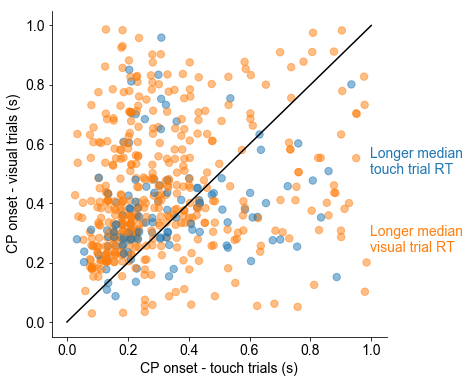

In [23]:
mpl.close('all')
fig, ax = mpl.subplots(1,1, figsize = (6,6))
# fig4_1.subplots_adjust(bottom = 0.15, wspace = 0.4, hspace = 0.4, right = 0.85)

color_array = np.array(['C0']*bimodal_lick_units['tac_onset'].shape[0])
color_array[vis_RT_longer] = 'C1'
ax.scatter(bimodal_lick_units['tac_onset']+np.random.rand(bimodal_lick_units.shape[0])*0.025/2, 
            bimodal_lick_units['vis_onset']+np.random.rand(bimodal_lick_units.shape[0])*0.025/2, 
            color = color_array, s = 55, alpha = 0.5)

ax.plot([-0,1], [-0,1], color = 'k')
ax.set_xlabel('CP onset - touch trials (s)')
ax.set_ylabel('CP onset - visual trials (s)')
ax.text(.95, .5, "Longer median\ntouch trial RT",transform=ax.transAxes, color = 'C0')
ax.text(.95, .26, "Longer median\nvisual trial RT",transform=ax.transAxes, color = 'C1')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# mpl.axis('scaled')
fig.savefig('RT_scatter.pdf', format = 'pdf', dpi = 900)

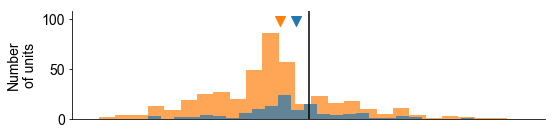

In [24]:
fig, ax = mpl.subplots(1,1, figsize = [np.sqrt(6**2+6**2),2])
proj_tac_long_RT = (bimodal_lick_units.loc[tac_RT_longer,'tac_onset']-bimodal_lick_units.loc[tac_RT_longer,'vis_onset'])*np.sqrt(2)
proj_vis_long_RT = (bimodal_lick_units.loc[vis_RT_longer,'tac_onset']-bimodal_lick_units.loc[vis_RT_longer,'vis_onset'])*np.sqrt(2)
proj_tac_long_hist = np.histogram(proj_tac_long_RT, bins = 25)
proj_vis_long_hist = np.histogram(proj_vis_long_RT, bins = 25)

ax.bar(proj_vis_long_hist[1][0:-1], proj_vis_long_hist[0],
       (proj_vis_long_hist[1][-1]-proj_vis_long_hist[1][0])/25, color = 'C1',alpha = 0.7)
ax.bar(proj_tac_long_hist[1][0:-1], proj_tac_long_hist[0],
       (proj_tac_long_hist[1][-1]-proj_tac_long_hist[1][0])/25, color = 'C0', alpha =0.7)

ymax = ax.get_ylim()[1] * 1.2
ax.plot([0,0], [0,ymax], color = 'k')
ax.set_ylim(0,ymax)
ax.set_xlim(-np.sqrt(2),np.sqrt(2))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.scatter(np.mean(proj_tac_long_RT), ymax*0.9, marker = 'v', s = 100)
ax.scatter(np.mean(proj_vis_long_RT), ymax*0.9, marker = 'v', s = 100, color = 'C1')
ax.set_ylabel('Number\nof units')
ax.axes.get_xaxis().set_visible(False)  
fig.savefig('RT_scatter_psth.pdf', format = 'pdf', dpi = 900)

In [25]:
onsets_licks = onsets.merge(med_first_lick)
touch_and_bimodal = onsets_licks[~onsets_licks['tac_onset'].isnull()]
visual_and_bimodal = onsets_licks[~onsets_licks['vis_onset'].isnull()]

In [26]:
scipy.stats.linregress(touch_and_bimodal.loc[:,'tac_RT'],touch_and_bimodal.loc[:, 'tac_onset'])
scipy.stats.linregress(visual_and_bimodal.loc[:,'vis_RT'],visual_and_bimodal.loc[:, 'vis_onset'])

LinregressResult(slope=0.285112525259854, intercept=0.2779047928335192, rvalue=0.21677444863559261, pvalue=4.979921855081291e-09, stderr=0.04815283599103446)

In [27]:
onsets = onsets.merge(med_first_lick)

tac_slope, tac_int, tac_r, _, _ = scipy.stats.linregress(touch_and_bimodal.loc[:,'tac_RT'],touch_and_bimodal.loc[:, 'tac_onset'])
vis_slope, vis_int, vis_r, _, _ = scipy.stats.linregress(visual_and_bimodal.loc[:,'vis_RT'],visual_and_bimodal.loc[:, 'vis_onset'])

x = [0.3, 1]
tac_fitline_values = [tac_slope * i + tac_int for i in x]
vis_fitline_values = [vis_slope * i + vis_int for i in x]

bimodal_lick_units['median_diff'] = bimodal_lick_units['tac_RT'] - bimodal_lick_units['vis_RT']
bimodal_lick_units['RT_index'] =  ((bimodal_lick_units['tac_RT'] - bimodal_lick_units['vis_RT'])/
                            (bimodal_lick_units['tac_RT'] + bimodal_lick_units['vis_RT']))
bimodal_lick_units['late_onset_diff'] = bimodal_lick_units['tac_onset'] - bimodal_lick_units['vis_onset']

bimodal_lick_units_RTsort = bimodal_lick_units.sort_values(['median_diff']).reset_index(drop=True)

diff_slope2, diff_int2, vis_r2, _, _ = scipy.stats.linregress(bimodal_lick_units.loc[:,'median_diff'],
                                                           bimodal_lick_units.loc[:, 'late_onset_diff'])
x2 = [-0.7, .3]
median_diff_fitline_values = [diff_slope2 * i + diff_int2 for i in x2]


In [28]:
mpl.close('all')
import random as rand
def cp_rt_corr(modality = 'touch', **kwargs):
    fig = mpl.figure(figsize = (7*size_mult,7*size_mult))
    gs1 = gridspec.GridSpec(1,1)
    gs2 = gridspec.GridSpec(1,1)
    gs3 = gridspec.GridSpec(1,1)
    
    gs1.update(left = 0.2, right = 0.66, bottom = 0.2, top = 0.66)
    gs2.update(left = 0.2, right = 0.66, bottom = 0.76, top = .9)
    gs3.update(left = 0.76, right = .9, bottom = 0.2, top = 0.66)

    ax1 = mpl.subplot(gs1[0,0])
    ax2 = mpl.subplot(gs2[0,0])
    ax3 = mpl.subplot(gs3[0,0])    

    range = [0,1]
    if modality == 'touch':
        rt = touch_and_bimodal.loc[:, 'tac_RT']
        cp = touch_and_bimodal.loc[:,'tac_onset']
        color = 'C0'
        xvals = x
        yvals = tac_fitline_values
        xlabel = 'Median reaction time (s)\ntouch trials'
        ylabel = 'Onset of late activity (s)\ntouch trials'
        r = tac_r
    elif modality == 'visual':
        rt = visual_and_bimodal.loc[:,'vis_RT']
        cp = visual_and_bimodal.loc[:, 'vis_onset']
        color = 'C1'
        xvals = x
        yvals = vis_fitline_values
        xlabel = 'Median reaction time (s)\nvisual trials'
        ylabel = 'Onset of late activity (s)\nvisual trials'
        r = vis_r
    elif modality == 'diff':
        rt = bimodal_lick_units['median_diff']
        cp = bimodal_lick_units['late_onset_diff']
        color = 'C6'
        xvals = x2
        yvals = median_diff_fitline_values
        xlabel = 'Median reaction time\ndifference (s)'
        ylabel = 'Late-activity\nonset difference'
        r= vis_r2
    elif modality == 'custom':
        rt = bimodal_lick_units.loc[:, 'tac_RT']
        cp = bimodal_lick_units.loc[:, 'max_tac']
        color = 'b'
        xvals = x
        yvals = x
        xlabel = 'Median reaction time (s)\ntouch trials'
        ylabel = 'peak of CP (s)\ntouch trials'
        r= vis_r2

    rt_count = np.histogram(rt, bins = np.arange(rt.min()+0.001, rt.max()+0.001,0.025))
    rt_med = rt.median()
    
    cp_count = np.histogram(cp, bins = np.arange(cp.min()+0.001, cp.max()+0.001,0.025))
    cp_med = cp.median()
    
    ax1.scatter(rt, cp, alpha = 0.4, color = color, s = 20*size_mult)
    ax1.plot(xvals, yvals, 'k')
    
    ax2.bar(rt_count[1][0:-1], rt_count[0]/len(rt), 0.025, color = color)
    ax2.plot([rt_med]*2, [0,.15], 'r')
    
    ax3.barh(cp_count[1][0:-1], cp_count[0]/len(cp), 0.025, color = color)
    ax3.plot([0,.15], [cp_med]*2, 'r')
    
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.text(.05, 0.98, "r$^2$ = "+str(np.around(r**2, 2)) , transform=ax1.transAxes, color = 'k')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.xaxis.set_ticks_position('bottom')
    ax1.yaxis.set_ticks_position('left')
    
    ax2.set_xticklabels([])
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_ylabel('Fraction')
    ax2.set_ylim(0,0.15)
    
    ax3.set_yticklabels([])
#     ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.set_xlabel('Fraction')
    ax3.set_xlim(0,0.15)

    if modality != 'diff':
        ax1.set_xlim(-0.025,1.2); ax1.set_ylim(-0.025,1.2)
        ax2.set_xlim(-0.025,1.2); ax3.set_ylim(-0.025,1.2)
        
    else:
        ax1.set_xlim(-1,0.75)
        ax1.set_ylim(-1,0.75)
        ax2.set_xlim(-1,0.75)
        ax3.set_ylim(-1,0.75)
       
    return fig

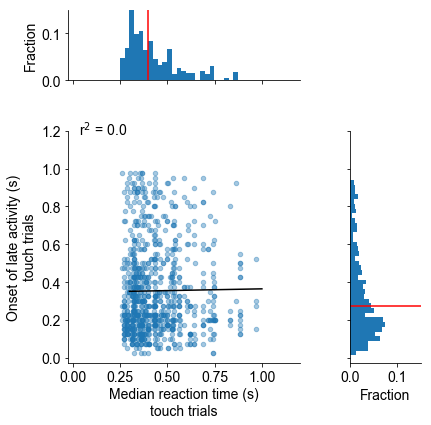

In [30]:
fig = cp_rt_corr(modality = 'touch')
# fig.savefig('tacRT_scatter.pdf', format = 'pdf', dpi = 900)

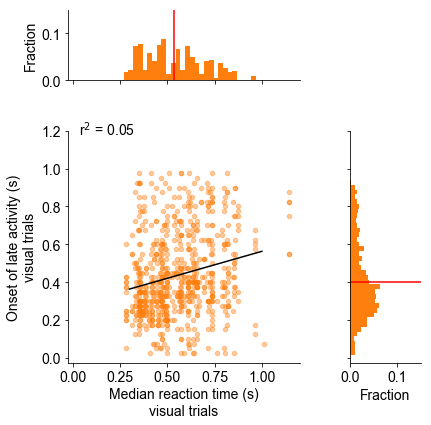

In [32]:
fig = cp_rt_corr(modality = 'visual')
# fig.savefig('visRT_scatter.pdf', format = 'pdf', dpi = 900)

In [33]:
from tqdm import tqdm_notebook

In [34]:

def get_tercile_rows(subset_df, stim_type):
    unit_grps = subset_df.groupby('uni_id')
    for _, unit_rows in tqdm_notebook(unit_grps): 
        if stim_type == 'touch':
            stim = unit_rows['trial_type'] == 'Stim_Som_NoCue'
        elif stim_type == 'short touch':
            stim = unit_rows['trial_type'] == '1CycStim_Som_NoCue'
        elif stim_type == 'visual':
            stim = unit_rows['trial_type'] == 'Stim_Vis_NoCue'
        elif stim_type == 'short visual':
            stim = unit_rows['trial_type'] == '1CycStim_Vis_NoCue'
            
        lick = (unit_rows['response'] != 0) & (unit_rows['correct'] == 1)
        no_lick = (unit_rows['response'] == 0) & (unit_rows['correct'] == 1)

        stim_no_lick_rows = unit_rows[stim & no_lick]
        stim_lick_rows = unit_rows[stim & lick]
        
        no_lick = list(stim_no_lick_rows.index)
        terciles = stim_lick_rows['first_lick'].quantile([.33, .67])
        first_terc = (list(stim_lick_rows.index[stim_lick_rows['first_lick'] <= terciles[.33]]))
        second_terc = (list(stim_lick_rows.index[(stim_lick_rows['first_lick'] > terciles[.33]) &
                                        ((stim_lick_rows['first_lick'] < terciles[.67]))]))
        third_terc = (list(stim_lick_rows.index[stim_lick_rows['first_lick']
                                                         >= terciles[.67]]))
        subset_df.loc[no_lick, 'terc_group'] = 0
        subset_df.loc[first_terc, 'terc_group'] = 1
        subset_df.loc[second_terc, 'terc_group'] = 2
        subset_df.loc[third_terc, 'terc_group'] = 3
        
    return subset_df


In [35]:
id_cols = ['mouse_name', 'date', 'cluster_name']
bi_units_trials = pd.merge(log_df, bimodal_lick_units['uni_id'].to_frame(), on = 'uni_id', how = 'right')
bi_units_trials['terc_group'] = -1
bi_units_trials = get_tercile_rows(bi_units_trials, stim_type = 'touch')
bi_units_trials = get_tercile_rows(bi_units_trials, stim_type = 'visual')
bi_units_trials = bi_units_trials[~bi_units_trials['trial_type'].str.contains('1Cyc')].reset_index(drop=True)

HBox(children=(IntProgress(value=0, max=545), HTML(value='')))

HBox(children=(IntProgress(value=0, max=545), HTML(value='')))

In [36]:
bi_units_trials.columns

Index(['mouse_name', 'date', 'block_type', 'trial_type', 'touch_stimulus',
       'vis_stimulus', 'response', 'trial_num', 'stim_onset', 'stim_offset',
       'licks_right', 'licks_left', 'spike_times', 'cluster_name',
       'spike_times(stim_aligned)', 'first_lick', 'last_lick', 'identified',
       'correct', 'contingency', 'uni_id', 'spike_counts(stim_aligned)',
       'trial_label', 'baseline_min', 'baseline_max', 'baseline_spike_count',
       'terc_group'],
      dtype='object')

In [37]:
bimodal_lick_units.shape

(545, 8)

In [38]:
bimodal_lick_units['FR_mean'] = np.nan
bimodal_lick_units['FR_std'] = np.nan
unit_grps = bi_units_trials.groupby('uni_id')
bin_size = 0.025
for unit, unit_rows in tqdm_notebook(unit_grps):
#     unit_rows = bi_units_trials[(bi_units_trials['mouse_name'] == bimodal_lick_units.loc[unit, 'mouse_name']) &
#                               (bi_units_trials['date'] == bimodal_lick_units.loc[unit,'date']) &
#                               (bi_units_trials['cluster_name'] == bimodal_lick_units.loc[unit,'cluster_name'])]
    
    ## since there are 8 trial types (short/long x touchStim/visStim x touchBlock/visBlock) will use random sample of
    ## 1/8 of all trials to calculate mean and std of baseline firing rate for each unit
    baseline_trial_inds = rand.sample(list(unit_rows.index), int(np.max(unit_rows['trial_num'])/24))
    bin_means = np.mean(np.stack(unit_rows.loc[baseline_trial_inds, 'baseline_spike_count'].as_matrix(), axis = 0), axis=0)/bin_size

    bimodal_lick_units.loc[bimodal_lick_units['uni_id'] == unit,'FR_mean'] = np.mean(bin_means)
    bimodal_lick_units.loc[bimodal_lick_units['uni_id'] == unit,'FR_std'] = np.std(bin_means)
    

bimodal_lick_units = bimodal_lick_units[bimodal_lick_units['FR_std'] != 0].reset_index(drop = True)

HBox(children=(IntProgress(value=0, max=545), HTML(value='')))

In [39]:
window = [-1, 3]
edges = np.arange(window[0], window[1], bin_size)

bi_units_trials['spike_counts(stim_aligned)'] = bi_units_trials['spike_times(stim_aligned)'].apply(
    lambda x: np.histogram(x,edges)[0]/bin_size)


conds = ['t_stim_no_lick', 't_stim_lick_first_terc', 't_stim_lick_second_terc', 't_stim_lick_third_terc',
        'v_stim_no_lick', 'v_stim_lick_first_terc', 'v_stim_lick_second_terc', 'v_stim_lick_third_terc']

z_conds = ['t_stim_no_lick(z_score)', 't_stim_lick_first_terc(z_score)', 't_stim_lick_second_terc(z_score)',
           't_stim_lick_third_terc(z_score)','v_stim_no_lick(z_score)', 'v_stim_lick_first_terc(z_score)',
           'v_stim_lick_second_terc(z_score)', 'v_stim_lick_third_terc(z_score)']

for c in range(8):
    bimodal_lick_units[conds[c]] = np.nan
    bimodal_lick_units[conds[c]] = bimodal_lick_units[conds[c]].astype(object)
    bimodal_lick_units[z_conds[c]] = np.nan
    bimodal_lick_units[z_conds[c]] = bimodal_lick_units[z_conds[c]].astype(object)
    

In [ ]:
bimodal_lick_units.shape

In [42]:
whisker = bi_units_trials['block_type'] == 'Whisker'
visual = bi_units_trials['block_type'] == 'Visual'
correct = bi_units_trials['correct'] == 1
lick = bi_units_trials['response'] != 0
lick_right = bi_units_trials['response'] == 1
lick_left = bi_units_trials['response'] == 2

t_stim = bi_units_trials['trial_type'].str.contains('Stim_Som')
v_stim = bi_units_trials['trial_type'].str.contains('Stim_Vis')

tt_key = pd.DataFrame()
tt_key['ts_nl'] = t_stim & (bi_units_trials['terc_group'] == 0)
tt_key['ts_ft'] = t_stim & (bi_units_trials['terc_group'] == 1)
tt_key['ts_st'] = t_stim & (bi_units_trials['terc_group'] == 2)
tt_key['ts_tt'] = t_stim & (bi_units_trials['terc_group'] == 3)
tt_key['vs_nl'] = v_stim & (bi_units_trials['terc_group'] == 0)
tt_key['vs_ft'] = v_stim & (bi_units_trials['terc_group'] == 1)
tt_key['vs_st'] = v_stim & (bi_units_trials['terc_group'] == 2)
tt_key['vs_tt'] = v_stim & (bi_units_trials['terc_group'] == 3)

tt_key.head()

,ts_nl,ts_ft,ts_st,ts_tt,vs_nl,vs_ft,vs_st,vs_tt
0,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False


In [43]:
for unit, unit_rows in tqdm_notebook(bi_units_trials.groupby('uni_id')):
   
    unit_tt = tt_key.loc[list(unit_rows.index)]
    
  
    trial_types = [unit_tt['ts_nl'],unit_tt['ts_ft'], unit_tt['ts_st'], unit_tt['ts_tt'],
                   unit_tt['vs_nl'], unit_tt['vs_ft'], unit_tt['vs_st'], unit_tt['vs_tt']]
    bin_means_all = []
    
    for j in range(8):
        tt_rows = unit_rows[trial_types[j].as_matrix()]
        if len(tt_rows['spike_counts(stim_aligned)'].as_matrix())<2:
            bin_means = np.array([np.nan]*159)
        else:
            bin_means = np.mean(np.stack(tt_rows['spike_counts(stim_aligned)'].as_matrix(), axis = 0), axis=0)
            
        baseline_mean = bimodal_lick_units.loc[bimodal_lick_units['uni_id'] == unit, 'FR_mean'].values
        baseline_std = bimodal_lick_units.loc[bimodal_lick_units['uni_id'] == unit, 'FR_std'].values
        
        bimodal_lick_units.loc[bimodal_lick_units['uni_id'] == unit, conds[j]] = [[bin_means]]

        bimodal_lick_units.loc[bimodal_lick_units['uni_id'] == unit, z_conds[j]] = [[(bin_means - baseline_mean)/baseline_std]]


HBox(children=(IntProgress(value=0, max=545), HTML(value='')))

In [44]:
trials_grpd = bi_units_trials[['uni_id','trial_type','terc_group', 'first_lick']].groupby(['uni_id','trial_type','terc_group'])

RT_median_table = trials_grpd.median()
RT_mean_table = trials_grpd.mean()
RT_std_table = trials_grpd.std()
RT_num_table = trials_grpd.size()


In [45]:
RT_median_table = RT_median_table.unstack().unstack()
cols = ['uni_id'] + [col[2]+'_'+str(col[1]) for col in RT_median_table.columns]
RT_median_table = RT_median_table.reset_index()
RT_median_table.columns = cols


In [46]:
bimodal_lick_units = bimodal_lick_units.merge(RT_median_table)

In [47]:
data = {}

columns = [['t_stim_lick_first_terc(z_score)', 'v_stim_lick_third_terc(z_score)'],
           ['t_stim_lick_third_terc(z_score)',  'v_stim_lick_first_terc(z_score)']]

for i,col in enumerate(columns):
    data[i] = [pd.DataFrame(np.vstack(bimodal_lick_units[z_map].values)) for z_map in col]


In [48]:
m_psth.shape

NameError: name 'm_psth' is not defined

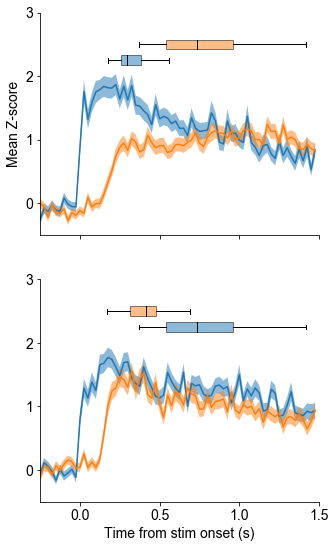

In [49]:
mpl.close('all')
fig, axs = mpl.subplots(2,1, figsize = (5,9), sharey = True, sharex = True)

colors = ['C0', 'C1',]

xvals = np.arange(-0.25,1.5,bin_size)
for i, col in enumerate(list(data.keys())):
    trial_types = data[col]
#     ax.add_patch(patches.Rectangle((0,0), 0.15, 1, facecolor = 'C0', alpha = 0.5))
#     ax.add_patch(patches.Rectangle((0,1), 0.15, 2, facecolor = 'C1', alpha = 0.5))
#     ax.set_ylim(0,2)

    ax.axis('off')

    for tt in trial_types:
        z_map = tt
        m_psth = z_map.mean(axis = 0)[30:100]
        sem_psth = scipy.stats.sem(z_map, axis = 0, nan_policy = 'omit')[30:100]
        axs[i].plot(xvals,m_psth)
        axs[i].fill_between(xvals, m_psth-sem_psth, m_psth+sem_psth,alpha=0.5,)
        axs[i].set_xlim(-0.25,1.5)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
axs[i].set_xlabel('Time from stim onset (s)')
            
ylim = axs[0].get_ylim()
bplot1 = axs[0].boxplot([RT_median_table['Stim_Som_NoCue_1'],RT_median_table['Stim_Vis_NoCue_3']], 
                     vert = False, positions = [2.25,2.5], showfliers = False,patch_artist = True)
bplot2 = axs[1].boxplot([RT_median_table['Stim_Vis_NoCue_3'],RT_median_table['Stim_Vis_NoCue_1']],
                     vert = False, positions = [2.25,2.5], showfliers = False,patch_artist = True)
axs[0].set_ylim(-0.5, 3)
axs[0].set_ylim(-0.5, 3)
axs[0].set_xlim(-0.25, 1.5)

axs[0].set_yticks([0,1,2,3])
axs[0].set_yticklabels([0,1,2,3])

axs[0].set_ylabel('Mean Z-score')

for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            mpl.setp(bplot[element], color='k')
        patch.set_facecolor(color)
        patch.set_alpha(0.5)
fig.savefig('terciles_RT.pdf', format = 'pdf', dpi = 900)